# Custom version of Stable Diffusion

In [1]:
!pip install transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.6 MB/s eta 0:00:0000:0100:01
  Using cached diffusers-0.6.0-py3-none-any.whl (255 kB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached tokenizers-0.13.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached huggingface_hub-0.10.1-py3-none-any.whl (163 kB)

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import math

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer

In [5]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.14.self_attn.out_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.15.mlp.fc2.weight', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.19.mlp.fc1.bias', 'vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.self_attn.q_

In [6]:
from diffusers import AutoencoderKL, UNet2DConditionModel

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [7]:
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

## Methods

In [8]:
def make_text_embs(promt, negative_prompt=""): 
    token_info = tokenizer([prompt], padding="max_length", truncation=True, return_tensors="pt")
    token_embs = text_encoder(token_info.input_ids.to("cuda"))[0];
    
     # make text_embs
    uncond_info = tokenizer([negative_prompt], padding="max_length", truncation=True, return_tensors="pt")
    uncond_embs = text_encoder(uncond_info.input_ids.to("cuda"))[0]
    text_embs = torch.cat([uncond_embs, token_embs])
    return text_embs

In [9]:
def gen_image(text_embs, height=512, width=512, steps=50, gd=7.5, seed=100, get_all=False, return_preview=False, stop_at_step=-1, input_latents=None, resume_step=-100):
    torch.manual_seed(seed)
    latents = torch.randn(len(text_embs)//2, unet.in_channels, height // 8, width // 8).to("cuda").half()
    
    scheduler.set_timesteps(steps) 
    
    if input_latents == None:
        latents = latents * scheduler.init_noise_sigma
    else:
        latents = input_latents
    
    latents_list = []
    
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i < resume_step:
            continue
                
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embs).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + gd * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        updated_info = scheduler.step(pred, t, latents)
        latents = updated_info.prev_sample
        
        if stop_at_step == i:
            return updated_info.pred_original_sample, latents
        
        if get_all:
            latents_list.append(updated_info.pred_original_sample if return_preview else latents)
    
    if get_all:
        return latents_list
    
    return latents

In [10]:
def decode_latents(latents, scale_factor=1.0):
    with torch.no_grad():
        im_data = vae.decode(latents * 1 / 0.18215).sample[0]
        
    norm_im_data = (im_data * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
    rgb_im_data = (norm_im_data * 255).round().astype("uint8")
    im = Image.fromarray(rgb_im_data)
    
    return im.resize(((int)(im.width * scale_factor), (int)(im.height * scale_factor)))

In [11]:
def show_latents_grid(latents_list, cols=8, scale_factor=1.0):
    images = [decode_latents(item, scale_factor) for item in latents_list]
    
    w,h = images[0].size
    rows = math.ceil(len(images) / cols)
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(images): 
        grid.paste(img, box=(i%cols*w, i//cols*h))
        
    return grid

### Usage

  0%|          | 0/50 [00:00<?, ?it/s]

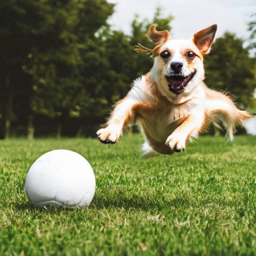

In [12]:
prompt = "a dog playing with a ball"
latents = gen_image(make_text_embs(prompt), steps=50)
decode_latents(latents, 0.5)

  0%|          | 0/50 [00:00<?, ?it/s]

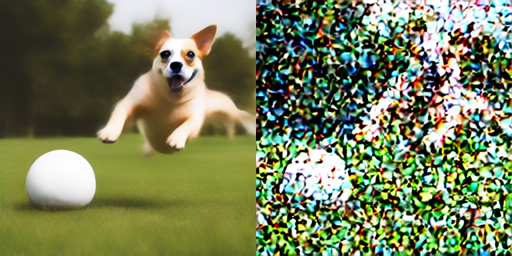

In [13]:
latents_list = gen_image(make_text_embs(prompt), steps=50, stop_at_step=25)
show_latents_grid(latents_list, scale_factor=0.5, cols=2)

  0%|          | 0/49 [00:00<?, ?it/s]

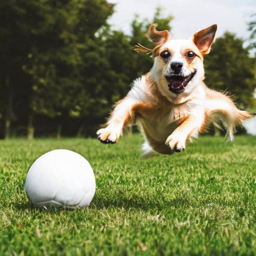

In [14]:
new_latent = gen_image(make_text_embs(prompt), steps=49, resume_step=26, input_latents=latents_list[1])
decode_latents(new_latent, 0.5)